<a href="https://colab.research.google.com/github/benjaminnigjeh/keyProteoforms/blob/main/Generalized_Transformer_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

# Load the pickled DataFrame
df = pd.read_pickle('/content/drive/MyDrive/databank_learner2.pkl')



In [2]:
!pip install pronto

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 2.9 MB/s eta 0:00:00


In [6]:
import torch
import numpy as np
import pronto
from torch.utils.data import Dataset

# Load PSI-MOD ontology
ontology = pronto.Ontology("/content/drive/MyDrive/PSI-MOD.obo")

def extract_mod_masses_and_locations(int_mod_str, n_term_str):
    masses = []
    locations = []

    def parse_mods(mod_str, force_position=None):
        mods = []
        if not isinstance(mod_str, str) or not any(prefix in mod_str for prefix in ("MOD:", "PSI-MOD:")):
            return mods

        for mod_entry in mod_str.split('|'):
            if '@' in mod_entry:
                mod_part, suffix = mod_entry.split('@')
                try:
                    suffix = int(suffix)
                except ValueError:
                    continue
            else:
                mod_part = mod_entry
                suffix = 0

            if ':' not in mod_part:
                continue

            prefix, number = mod_part.split(':')
            if not number.isdigit():
                continue

            padded_number = number.zfill(5)
            mod_id = f"MOD:{padded_number}"  # Always use MOD:xxxxx for lookup

            if force_position is not None:
                suffix = force_position

            mods.append((mod_id, suffix))
        return mods

    mod_list = parse_mods(n_term_str, force_position=0) + parse_mods(int_mod_str)

    for mod_id, location in mod_list:
        locations.append(location)
        try:
            xrefs = ontology[mod_id].xrefs
            diffavg_desc = next((x.description for x in xrefs if x.id == "DiffAvg:"), None)
            masses.append(float(diffavg_desc))
        except (KeyError, TypeError, ValueError):
            masses.append(0.0)

    return masses, locations


def create_tertiary_mask_with_mass_shifts(canonical_seq, t_seq, ptm_locs, mass_shifts):
    """
    Returns:
    - mask: torch.LongTensor of shape [len(canonical_seq)], values in {0, 1, 2}
    - mass_vector: torch.FloatTensor of shape [len(canonical_seq)], nonzero only at PTM sites
    """
    if len(ptm_locs) != len(mass_shifts):
        raise ValueError(f"Mismatch: {len(ptm_locs)} PTM locations vs {len(mass_shifts)} mass shifts.")

    seq_len = len(canonical_seq)
    mask = torch.zeros(seq_len, dtype=torch.long)         # ensure long for CE loss
    mass_vector = torch.zeros(seq_len, dtype=torch.float32)

    start_idx = canonical_seq.find(t_seq)
    if start_idx == -1:
        raise ValueError(f"Truncated sequence '{t_seq}' not found in canonical sequence.")

    # Mark entire truncated region as "truncated" = 1
    mask[start_idx:start_idx + len(t_seq)] = 1

    # Mark PTM positions as 2 and assign their mass shifts
    for rel_idx, shift in zip(ptm_locs, mass_shifts):
        abs_idx = start_idx + rel_idx
        if not (0 <= abs_idx < seq_len):
            raise IndexError(f"PTM index {abs_idx} out of bounds for sequence length {seq_len}")
        mask[abs_idx] = 2
        mass_vector[abs_idx] = shift

    return mask, mass_vector


class PTMDataset(Dataset):
    def __init__(self, spectra, labels, deltas):
        assert len(spectra) == len(labels) == len(deltas), "All input lists must be the same length."

        self.spectra = [
            s if isinstance(s, torch.Tensor) else torch.tensor(np.array(s), dtype=torch.float32)
            for s in spectra
        ]
        self.labels = labels
        self.deltas = deltas

    def __len__(self):
        return len(self.spectra)

    def __getitem__(self, idx):
        return self.spectra[idx], self.labels[idx], self.deltas[idx]


In [ ]:
spectra = []
labels = []
deltas = []

for i in range(len(df)):
    if df['Uniprot ID'][i] == 'HBB_HUMAN':
        spec = df['cast spectra'][i]
        canonical_seq = "MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKVKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH"
        #canonical_seq = "MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR"
        t_seq = df['sequence'][i]
        int_mod_str = df['int_mod'][i]
        n_term_str = df['n_term'][i]

        try:
            masses, locations = extract_mod_masses_and_locations(int_mod_str, n_term_str)


            # Filter for only modifications within the canonical sequence
            valid_idxs = [i for i, loc in enumerate(locations) if 0 <= loc < len(canonical_seq)]
            ptm_locs = [locations[i] for i in valid_idxs]
            ptm_masses = [masses[i] for i in valid_idxs]

            mask, mass_vec = create_tertiary_mask_with_mass_shifts(canonical_seq, t_seq, ptm_locs, ptm_masses)

            spectra.append(spec)
            labels.append(mask)
            deltas.append(mass_vec)



        except Exception as e:
            print(f"Skipping index {i} due to error: {e}")


dataset = PTMDataset(spectra, labels, deltas)


In [8]:
from torch.utils.data import DataLoader, random_split

# Example: 80% training, 20% testing
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Epoch 1: Loss = 0.0125 | Precision = 0.1775 | Recall = 0.0683 | F1 = 0.0987
Epoch 2: Loss = 0.0059 | Precision = 0.5421 | Recall = 0.2654 | F1 = 0.3563
Epoch 3: Loss = 0.0054 | Precision = 0.5678 | Recall = 0.3054 | F1 = 0.3971
Epoch 4: Loss = 0.0052 | Precision = 0.5806 | Recall = 0.3231 | F1 = 0.4152
Epoch 5: Loss = 0.0051 | Precision = 0.5904 | Recall = 0.3453 | F1 = 0.4358
Epoch 6: Loss = 0.0050 | Precision = 0.5992 | Recall = 0.3677 | F1 = 0.4557
Epoch 7: Loss = 0.0050 | Precision = 0.6032 | Recall = 0.3750 | F1 = 0.4625
Epoch 8: Loss = 0.0049 | Precision = 0.6068 | Recall = 0.3920 | F1 = 0.4763
Epoch 9: Loss = 0.0049 | Precision = 0.6118 | Recall = 0.3966 | F1 = 0.4812
Epoch 10: Loss = 0.0048 | Precision = 0.6156 | Recall = 0.4079 | F1 = 0.4907

[TEST] Precision = 0.6023 | Recall = 0.4539 | F1 = 0.5176


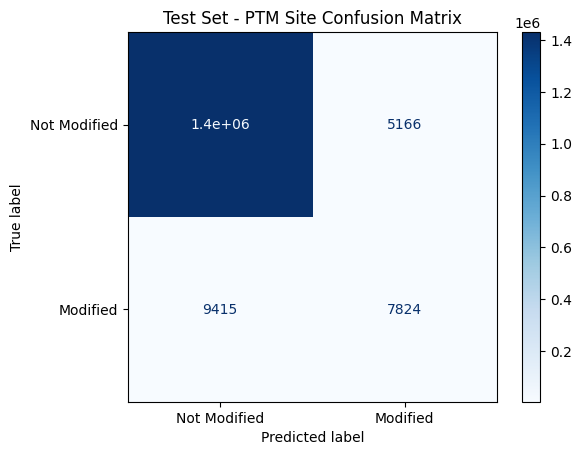

In [9]:
import torch
import torch.nn as nn
import math
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# --- Positional Encoding ---
class PositionalEncoding1D(nn.Module):
    def __init__(self, d_model, max_len=147):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# --- Binary PTM Site Classifier ---
class PTMSiteClassifier(nn.Module):
    def __init__(self, input_dim=1600, seq_len=147):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, 256)
        self.encoder_pos_enc = PositionalEncoding1D(256, max_len=seq_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model=256, nhead=8, dim_feedforward=512, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
        self.head = nn.Linear(256, 1)  # Binary classifier

    def forward(self, spectra):
        x = self.input_proj(spectra).unsqueeze(1).repeat(1, 147, 1)
        x = self.encoder_pos_enc(x)
        x = self.encoder(x)
        return self.head(x).squeeze(-1)  # [B, 147]

# --- Focal Loss for Binary Classification ---
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.9, gamma=2.0, reduction="mean"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        bce = nn.functional.binary_cross_entropy_with_logits(logits, targets, reduction="none")
        probas = torch.sigmoid(logits)
        pt = probas * targets + (1 - probas) * (1 - targets)
        focal = self.alpha * (1 - pt) ** self.gamma * bce
        return focal.mean() if self.reduction == "mean" else focal.sum()

# --- Training ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PTMSiteClassifier().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = FocalLoss(alpha=0.9, gamma=2.0)

for epoch in range(10):
    model.train()
    total_loss = 0
    all_preds, all_true = [], []

    for spectra, status_labels, _ in train_loader:
        spectra = spectra.to(DEVICE)
        is_modified = (status_labels == 2).float().to(DEVICE)  # Binary target

        optimizer.zero_grad()
        logits = model(spectra)  # [B, 147]
        loss = loss_fn(logits, is_modified)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        all_preds.extend(preds.cpu().numpy().ravel())
        all_true.extend(is_modified.cpu().numpy().ravel())

    precision = precision_score(all_true, all_preds, zero_division=0)
    recall = recall_score(all_true, all_preds, zero_division=0)
    f1 = f1_score(all_true, all_preds, zero_division=0)
    print(f"Epoch {epoch+1}: Loss = {total_loss/len(train_loader):.4f} | Precision = {precision:.4f} | Recall = {recall:.4f} | F1 = {f1:.4f}")

# --- Evaluation on Test Set ---
model.eval()
all_preds, all_true = [], []

with torch.no_grad():
    for spectra, status_labels, _ in test_loader:
        spectra = spectra.to(DEVICE)
        is_modified = (status_labels == 2).float().to(DEVICE)
        logits = model(spectra)
        preds = (torch.sigmoid(logits) > 0.5).float()

        all_preds.extend(preds.cpu().numpy().ravel())
        all_true.extend(is_modified.cpu().numpy().ravel())

# --- Metrics & Confusion Matrix ---
precision = precision_score(all_true, all_preds, zero_division=0)
recall = recall_score(all_true, all_preds, zero_division=0)
f1 = f1_score(all_true, all_preds, zero_division=0)
print(f"\n[TEST] Precision = {precision:.4f} | Recall = {recall:.4f} | F1 = {f1:.4f}")

cm = confusion_matrix(all_true, all_preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Modified", "Modified"])
disp.plot(cmap="Blues")
plt.title("Test Set - PTM Site Confusion Matrix")
plt.show()


Epoch 1: Loss = 2517.5338 | MAE on PTMs = 45.2349
Epoch 2: Loss = 1771.3188 | MAE on PTMs = 36.1049
Epoch 3: Loss = 1168.1226 | MAE on PTMs = 27.3504
Epoch 4: Loss = 758.5860 | MAE on PTMs = 20.8956
Epoch 5: Loss = 451.8379 | MAE on PTMs = 15.0133
Epoch 6: Loss = 237.8226 | MAE on PTMs = 10.8636
Epoch 7: Loss = 108.3177 | MAE on PTMs = 7.3013
Epoch 8: Loss = 43.2799 | MAE on PTMs = 4.6507
Epoch 9: Loss = 15.2653 | MAE on PTMs = 2.7251
Epoch 10: Loss = 5.8441 | MAE on PTMs = 1.5232

[TEST] Delta Mass MAE on PTM Sites = 0.9811


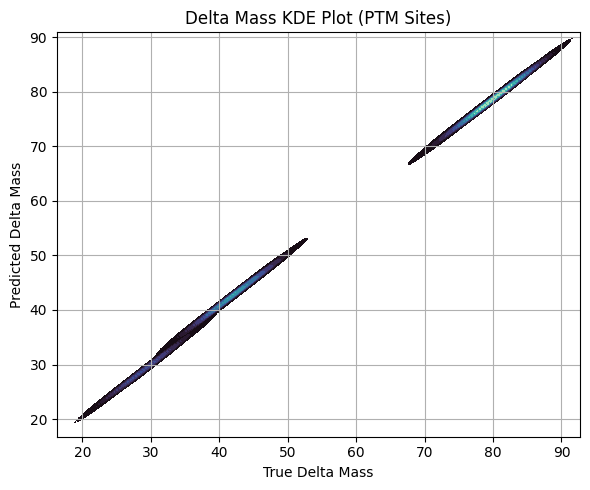

In [10]:
import torch
import torch.nn as nn
import math
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import mean_absolute_error

# --- Positional Encoding ---
class PositionalEncoding1D(nn.Module):
    def __init__(self, d_model, max_len=147):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# --- Delta Mass Regressor ---
class DeltaMassRegressor(nn.Module):
    def __init__(self, input_dim=1600, seq_len=147):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, 256)
        self.encoder_pos_enc = PositionalEncoding1D(256, max_len=seq_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model=256, nhead=8, dim_feedforward=512, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
        self.regressor = nn.Linear(256, 1)  # Predict delta mass

    def forward(self, spectra):
        x = self.input_proj(spectra).unsqueeze(1).repeat(1, 147, 1)
        x = self.encoder_pos_enc(x)
        x = self.encoder(x)
        return self.regressor(x).squeeze(-1)  # [B, 147]

# --- Training ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeltaMassRegressor().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

for epoch in range(10):
    model.train()
    total_loss = 0
    all_preds, all_true = [], []

    for spectra, status_labels, delta_labels in train_loader:
        spectra = spectra.to(DEVICE)
        is_modified = (status_labels == 2)
        delta_labels = delta_labels.to(DEVICE)

        optimizer.zero_grad()
        pred_deltas = model(spectra)  # [B, 147]

        # Only compute loss on modified positions
        loss = loss_fn(pred_deltas[is_modified], delta_labels[is_modified]) if is_modified.any() else torch.tensor(0.0, device=DEVICE)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        all_preds.extend(pred_deltas[is_modified].detach().cpu().numpy())
        all_true.extend(delta_labels[is_modified].cpu().numpy())

    mae = mean_absolute_error(all_true, all_preds) if all_true else 0.0
    print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f} | MAE on PTMs = {mae:.4f}")

# --- Evaluation on Test Set ---
import seaborn as sns

# --- Evaluation on Test Set ---
model.eval()
all_preds, all_true = [], []

with torch.no_grad():
    for spectra, status_labels, delta_labels in test_loader:
        spectra = spectra.to(DEVICE)
        is_modified = (status_labels == 2)
        delta_labels = delta_labels.to(DEVICE)
        pred_deltas = model(spectra)

        all_preds.extend(pred_deltas[is_modified].cpu().numpy())
        all_true.extend(delta_labels[is_modified].cpu().numpy())

mae = mean_absolute_error(all_true, all_preds) if all_true else 0.0
print(f"\n[TEST] Delta Mass MAE on PTM Sites = {mae:.4f}")

# --- Density Plot: True vs Predicted ---
plt.figure(figsize=(6, 5))
sns.kdeplot(x=all_true, y=all_preds, fill=True, cmap="mako", thresh=0.05)
plt.xlabel("True Delta Mass")
plt.ylabel("Predicted Delta Mass")
plt.title("Delta Mass KDE Plot (PTM Sites)")
plt.grid(True)
plt.tight_layout()
plt.show()


#Data landscape of the target protein

In [11]:
hbb_int_mod = []
for i in range(len(df)):
  if df['Uniprot ID'][i] == 'HBB_HUMAN':
    hbb_int_mod.append(df['int_mod'][i])

In [12]:
import numpy as np
from collections import Counter
import pronto

# Load ontology
ontology = pronto.Ontology("/content/drive/MyDrive/PSI-MOD.obo")

# Input array
mod_array = hbb_int_mod

# Extract and normalize PSI-MOD IDs
psi_mods = []
for entry in mod_array:
    if isinstance(entry, str):
        mods = entry.split('|')
        for mod in mods:
            if mod.startswith('PSI-MOD:'):
                base = mod.split('@')[0]
                number = base.split(':')[1].zfill(5)
                psi_mods.append(f"MOD:{number}")

# Count frequencies
psi_mod_counts = Counter(psi_mods)
sorted_counts = sorted(psi_mod_counts.items(), key=lambda x: x[1], reverse=True)

# Print frequencies and DiffAvg
print("MOD ID\tFrequency\tDiffAvg")
for mod_id, count in sorted_counts:
    try:
        xrefs = ontology[mod_id].xrefs
        diffavg = next((x.description for x in xrefs if x.id == "DiffAvg:"), None)
    except Exception as e:
        diffavg = f"Error: {e}"
    print(f"{mod_id}\t{count}\t\t{diffavg}")


MOD ID	Frequency	DiffAvg
MOD:00394	37472		42.04
MOD:00047	23858		79.98
MOD:00696	21131		79.98
MOD:00235	19671		29.00
MOD:00280	2201		70.05


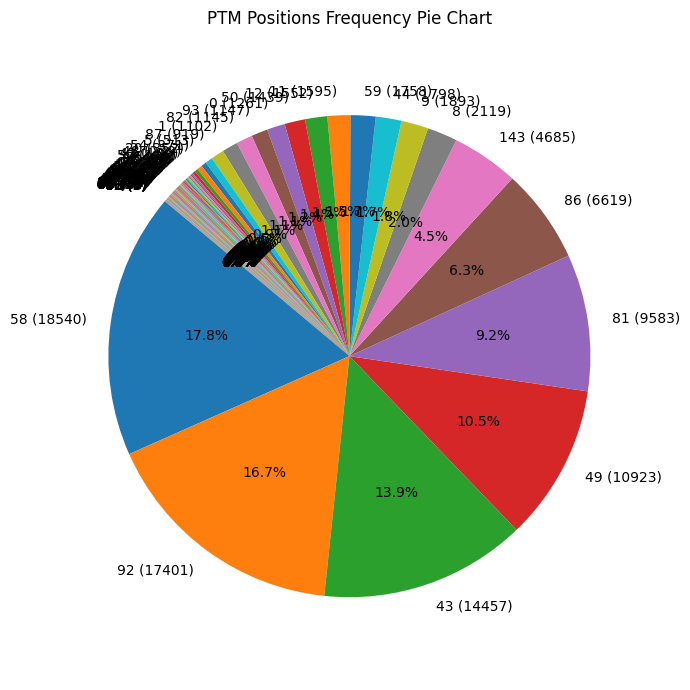

In [13]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_ptm_position_pie(mod_array, title="PTM Positions Frequency Pie Chart"):
    """
    Extracts positions from PSI-MOD annotations (after '@'), counts frequency,
    and plots a pie chart.

    Parameters:
        mod_array (list of str): e.g., ['PSI-MOD:394@2|PSI-MOD:394@25', 'PSI-MOD:47@30']
        title (str): Pie chart title
    """
    position_list = []

    for entry in mod_array:
        if isinstance(entry, str):
            mods = entry.split('|')
            for mod in mods:
                if '@' in mod:
                    try:
                        pos = int(mod.split('@')[1])
                        position_list.append(pos)
                    except ValueError:
                        continue

    if not position_list:
        print("No valid positions found.")
        return

    # Count and sort
    position_counts = Counter(position_list)
    sorted_counts = sorted(position_counts.items(), key=lambda x: x[1], reverse=True)

    # Prepare for pie chart
    labels = [f"{pos} ({count})" for pos, count in sorted_counts]
    sizes = [count for _, count in sorted_counts]

    # Plot
    plt.figure(figsize=(7, 7))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# === Example usage ===
if __name__ == "__main__":
    mod_array = hbb_int_mod
    plot_ptm_position_pie(mod_array)


In [16]:
import matplotlib.pyplot as plt
from collections import Counter

def analyze_ptm_position_recall(model, test_loader, device):
    model.eval()
    position_hits = Counter()
    position_total = Counter()

    with torch.no_grad():
        for spectra, status_labels, _ in test_loader:
            spectra = spectra.to(device)
            logits = model(spectra)
            preds = (torch.sigmoid(logits) > 0.50).float()
            status_labels = status_labels.cpu()

            for i in range(status_labels.size(0)):
                for j in range(status_labels.size(1)):
                    if status_labels[i, j] == 2:
                        position_total[j] += 1
                        if preds[i, j] == 1:
                            position_hits[j] += 1

    # Print recall per position
    print("\nPosition\tRecall (%)\tHits\tTotal")
    for pos in sorted(position_total.keys()):
        hits = position_hits[pos]
        total = position_total[pos]
        recall_pct = 100.0 * hits / total if total > 0 else 0.0
        print(f"{pos}\t\t{recall_pct:.2f}%\t\t{hits}\t{total}")

    # Prepare data for plotting
    positions = sorted(position_total.keys())
    totals = [position_total[pos] for pos in positions]
    recall_pct = [100.0 * position_hits[pos] / position_total[pos] if position_total[pos] > 0 else 0 for pos in positions]

    # Plot
    plt.figure(figsize=(8, 5))
    plt.scatter(totals, recall_pct, color='darkgreen')

    # Annotate each point with the position number
    for x, y, pos in zip(totals, recall_pct, positions):
        plt.text(x + 0.5, y, str(pos-1), fontsize=18, ha='left', va='center')

    plt.xlabel("Total True PTMs at Position")
    plt.ylabel("Recall (%)")
    plt.title("Recall vs Total Number of PTMs per Position")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
analyze_ptm_position_recall(model, test_loader, device= DEVICE)